In [44]:
import pandas as pd
import numpy as np

import ast
import pickle

import snap

%matplotlib inline

In [4]:
path = 'output/test-2/'
cluster_data = pd.read_csv(path+'1_step_user_groups.csv', sep='\t')

In [5]:
cluster_tags = pd.read_csv(path+'1_step_tags_clusters.txt', sep='\t')
cluster_tags.head()

n_cluster   dim                                           hashtags
0         -1  1618                                                  /
1          0  6828                                                  /
2          1    16  interiorinspo,decora,interiordecor,interiorsty...
3          2    35  disney,instacat,gato,princess,ladyboss,poetryc...
4          3    14  europa,fashionstylist,voyage,argentina,aloha,e...

In [9]:
# filter clusters that are not relevant
#cluster_data = cluster_data[cluster_data['num_users'] > 1]
cluster_data.head()

id_cluster  num_users                                         list_users
0           1         17  ('citychic4ever__', 0.9411764705882353), ('raw...
1           2         16  ('len_cap', 1.0), ('crown_rising', 0.823529411...
2           3         15  ('rimaglio', 1.0), ('pollyonvoyage', 0.8235294...
3           4          1                  ('ber_maria', 0.8823529411764706)
4           5          2  ('mynnorthamerica', 0.8823529411764706), ('gra...

In [6]:
def filterUsers(userlist):
    userlist = list(ast.literal_eval(userlist))
    result = []
    for userdata in userlist:
        if userdata[1] <= 0.5:
            result.append(userdata)
    return result

In [18]:
def getCompleteUserlist(userlist, cluster_dim):
    userlist = list(ast.literal_eval(userlist))
    result = []
    if cluster_dim > 1:
        for userdata in userlist:
            result.append(userdata[0])
    else:
        result.append(userlist[0])
    return result

In [19]:
# keep only relevant users (== consumers)
#cluster_data['relevant_users'] = cluster_data.apply(lambda x: filterUsers(x['list_users']), axis=1)
cluster_data['all_users'] = cluster_data.apply(lambda x: getCompleteUserlist(x['list_users'], x['num_users']), axis=1)
cluster_data.head()

id_cluster  num_users                                         list_users  \
0           1         17  ('citychic4ever__', 0.9411764705882353), ('raw...   
1           2         16  ('len_cap', 1.0), ('crown_rising', 0.823529411...   
2           3         15  ('rimaglio', 1.0), ('pollyonvoyage', 0.8235294...   
3           4          1                  ('ber_maria', 0.8823529411764706)   
4           5          2  ('mynnorthamerica', 0.8823529411764706), ('gra...   

                                           all_users  
0  [citychic4ever__, rawcontent, magalyopice, lib...  
1  [len_cap, crown_rising, murrymckee, ashcebulka...  
2  [rimaglio, pollyonvoyage, melrosexclusive, man...  
3                                        [ber_maria]  
4                 [mynnorthamerica, grantbriskinphl]

In [52]:
with open('output/1_step_consumers.csv', 'w') as outfile:
    outfile.write('n_cluster\tn_users\tconsumers_list\n')
    for c in cluster_data['id_cluster']:
        cluster = cluster_data[cluster_data['id_cluster'] == c]['relevant_users'].values[0]
        dim = len(cluster)
    
        outfile.write('{}\t{}\t{}\n'.format(c, dim, str(cluster).strip('[]')))

In [11]:
# read source network
network = snap.LoadEdgeListNet('data/followers_network.csv', '\t')

V = network.GetNodes()

In [20]:
# use all the users to expand the clusters
temp_result = []
for c in cluster_data['id_cluster']:
    c_users = cluster_data[cluster_data['id_cluster'] == c]['all_users'].values[0]
    
    it = network.BegNI()
    tag_ids = snap.TIntV()
    for i in range(V):
        nid = it.GetId()
        type = network.GetStrAttrDatN(nid, 'type')
        username = network.GetStrAttrDatN(nid, 'content')

        if type == 'user' and username in c_users:
            # add all tags of user
            tags = snap.TIntV()
            snap.GetNodesAtHop(network, nid, 2, tags, True)
            tag_ids.AddV(tags)

        it.Next()
        
    tag_ids.Merge() 
    
    alltags = set()
    for tid in tag_ids:
        tagname = network.GetStrAttrDatN(tid, 'content')
        alltags.add(tagname)
        
    c_tags = set(cluster_tags[cluster_tags['n_cluster'] == c]['hashtags'].values[0].split(','))
    newtags = alltags - c_tags
    
    temp_result.append(tuple((c, newtags)))

In [21]:
extended_cluster_tags = pd.DataFrame(temp_result, columns=['n_cluster', 'hashtags'])

In [44]:
with open('output/2_step_tags_clusters.txt', 'w') as outfile:
    outfile.write('n_cluster\tdim\thashtags\n')
    for c in extended_cluster_tags['n_cluster']:
        cluster = extended_cluster_tags[extended_cluster_tags['n_cluster'] == c]['hashtags'].values[0]
        dim = len(cluster)
    
        outfile.write('{}\t{}\t{}\n'.format(c, dim, ','.join(list(cluster))))

In [22]:
#extended_cluster_tags['hashtags'] = extended_cluster_tags.apply(lambda x: x['hashtags'], for axis=1)
test = set()
for s in extended_cluster_tags['hashtags']:
    print len(s)
    test = test.union(s)

201
191
202
2
11
120
29
429
1
242
40
66
18
3
157
64
1
122
177
160
19
1
65
20
17
146
3
36
1
3
7
64
56
99
69
19


In [23]:
len(test)

2058

In [24]:
i = 10
print extended_cluster_tags.iloc[i]['n_cluster']
print extended_cluster_tags.iloc[i]['hashtags']

11
set(['ch', 'southbeach', 'goldenhour', 'eastend', 'fbf', 'verbier', 'thedisimones', 'garden', 'tokyobike', 'rooftop', 'kittycat', 'rose', 'jcrew', 'sakura', 'instapassport', 'aboutlastnight', 'ski', 'manhattan', 'goodmorning', 'losangeles', 'tourist', 'dtla', 'mountainlife', 'truelove', 'market', 'flores', 'pepinodisimone', 'nyc', 'bythesea', 'henrythepiggy', 'nyceats', 'colour', 'suisse', 'morning', 'blueberry', 'mexicocity', 'switzerland', 'dise', 'palmsprings', 'fe'])


In [25]:
# store for next iterations/runs
usedtags = pickle.load(open('output/user-tags-list.pkl', 'r'))

In [26]:
# compute participation 
tempResult = []
for u in usedtags:
    u_vector = usedtags[u]
    
    if len(u_vector)>0:
        u_result = [u]
        for c in extended_cluster_tags['n_cluster']:
            c_vector = extended_cluster_tags[extended_cluster_tags['n_cluster'] == c]['hashtags'].values[0]
            participation = float(len(u_vector.intersection(c_vector)))/len(u_vector)
            u_result.append(participation)
    else:
        u_result = [u]+[0 for i in extended_cluster_tags['n_cluster']]
    tempResult.append(tuple(u_result))

In [27]:
result_header = ['username']+[c for c in extended_cluster_tags['n_cluster']]
participationTable = pd.DataFrame(tempResult, columns=result_header)

In [28]:
participationTable.head()

username         1    2         3    4    5         6         7  \
0  martaferrari9008  0.500000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
1          rsersale  0.058824  0.0  0.000000  0.0  0.0  0.000000  0.000000   
2           tlashab  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
3          charr114  0.058824  0.0  0.117647  0.0  0.0  0.117647  0.058824   
4          catespin  0.058824  0.0  0.000000  0.0  0.0  0.000000  0.000000   

          8    9 ...    27   28   29   30        31   32        33        34  \
0  0.000000  0.0 ...   0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000   
1  0.117647  0.0 ...   0.0  0.0  0.0  0.0  0.000000  0.0  0.176471  0.000000   
2  0.000000  0.0 ...   0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000   
3  0.294118  0.0 ...   0.0  0.0  0.0  0.0  0.058824  0.0  0.000000  0.058824   
4  0.176471  0.0 ...   0.0  0.0  0.0  0.0  0.058824  0.0  0.000000  0.000000   

         35   36  
0  0.000000  0.0  
1  0.000000  0.0  
2  0.000000  0.0  
3  0.117647  0.0  
4  0.058824  0.0  

[5 rows x 37 columns]

In [42]:
participationTable.to_csv('output/2_step_user_participation.csv', index=None)

In [60]:
first_step_cons = set()
for userlist in cluster_data['relevant_users']:
    for u in userlist:
        first_step_cons.add(u[0])

In [61]:
len(first_step_cons)

167

In [68]:
with open('output/2_step_user_groups.csv', 'w') as outfile:
    outfile.write('id_cluster\tnum_users\tlist_users\n')
    for i in extended_cluster_tags['n_cluster']:
        group = participationTable[participationTable[i] != 0.0]
        group.sort_values(by=i, ascending = False, inplace=True)
        
        userlist = [tuple((x['username'], x[i])) for index, x in group.iterrows() if x['username'] not in first_step_cons]
        
        dim = len(userlist)
        outfile.write('{}\t{}\t{}\n'.format(i, dim, str(userlist).strip('[]')))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Visualization of clusters and extension

In [31]:
first_step = cluster_tags.merge(cluster_data, left_on='n_cluster', right_on='id_cluster')[['id_cluster','dim','num_users']]

In [33]:
extended_cluster_tags['dim_2'] = extended_cluster_tags.apply(lambda x: len(x['hashtags']), axis=1)
extended_cluster_tags

n_cluster                                           hashtags  dim_2
0           1  {exclusive, deco, wynn, designerdeinteriores, ...    201
1           2  {laurito, ashcebulka, consciousness, savannah,...    191
2           3  {exclusive, parisianchic, deco, shot, maiolich...    202
3           4                                {makeup, editorial}      2
4           5  {plants, decor, snakes, marketing, interiordes...     11
5           6  {datenight, artwork, washingtondc, candcapprov...    120
6           7  {summer, cuteshoes, yachtlife, onepieceswimsui...     29
7           8  {monterey, thegoodlife, blackandwhite, dance, ...    429
8           9                                       {cabanamood}      1
9          10  {poetryfoundation, summer, help, blackandwhite...    242
10         11  {ch, southbeach, goldenhour, eastend, fbf, ver...     40
11         12  {whimsical, lovegardening, aegean, september, ...     66
12         13  {loveher, libertyoflondon, palmsprings, angel,...     18
13         14                 {breath, poetry, wordsthatbreathe}      3
14         15  {summer, torino, accessorize, streetstyle, fas...    157
15         16  {charcuterie, allday, southhampton, angel, sum...     64
16         17                                       {oneofakind}      1
17         18  {starphotographic, chain, moments, iamproject,...    122
18         19  {sanctuary, mexican, positanoamalficoast, gold...    177
19         20  {roh, datenight, tropics, cinqueterre, brother...    160
20         21  {shop, exclusive, venice, fashionweek, natural...     19
21         22                                    {luxurywedding}      1
22         23  {burberry, igerspuglia, meandyou, parco, bella...     65
23         24  {tokyobike, josephdirand, sunglasses, saveurma...     20
24         25  {igerssavona, johns, larivieradelsurf, dunasde...     17
25         26  {inspira, walking, fitfam, designerdeinteriore...    146
26         27                              {enjoy, party, night}      3
27         28  {besttime, couplegoals, happygirl, feelings, g...     36
28         29                                              {gay}      1
29         30                     {life, ilovemyjob, travelgram}      3
30         31  {summermood, bodrum, summer2017, minikoshop, p...      7
31         32  {enjoy, charcuterie, artdirection, allday, art...     64
32         33  {enjoy, concert, angel, rainyday, mykonos2017,...     56
33         34  {summer, maezaeworkshops, manchester, dise, iz...     99
34         35  {enjoy, pregnantlife, babygirl, destination, f...     69
35         36  {rideyourtime, visualmobs, getoutstayout, thec...     19

In [35]:
first_step_users = set()
for userlist in cluster_data['all_users']:
    for u in userlist:
        first_step_users.add(u[0])

In [36]:
user_2 = []
for i in range(1,37):
    group = participationTable[participationTable[i] != 0.0]
    group.sort_values(by=i, ascending = False, inplace=True)

    userlist = [tuple((x['username'], x[i])) for index, x in group.iterrows() if x['username'] not in first_step_users]

    dim = len(userlist)
    user_2.append(tuple((i, dim)))

/home/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [40]:
second_step = first_step.merge(extended_cluster_tags[['n_cluster','dim_2']], left_on='id_cluster', right_on='n_cluster')\
                        .merge(pd.DataFrame(user_2, columns=['id_cluster', 'num_users_2']), on='id_cluster')
second_step

id_cluster  dim  num_users  n_cluster  dim_2  num_users_2
0            1   16         17          1    201          481
1            2   35         16          2    191          419
2            3   14         15          3    202          545
3            4   15          1          4      2           18
4            5   15          2          5     11           83
5            6   18          9          6    120          500
6            7   24          4          7     29          153
7            8   27         32          8    429          872
8            9   16          1          9      1            3
9           10   31         19         10    242          605
10          11   14          5         11     40          166
11          12   16          5         12     66          145
12          13   15          2         13     18           35
13          14   14          1         14      3            6
14          15   28         12         15    157          447
15          16   17          5         16     64          194
16          17   16          1         17      1           11
17          18   12          9         18    122          433
18          19   36         15         19    177          565
19          20   16         13         20    160          535
20          21   14          2         21     19           96
21          22   16          1         22      1            2
22          23   14          5         23     65          188
23          24   13          2         24     20           54
24          25   16          2         25     17           16
25          26   14         10         26    146          447
26          27   14          1         27      3           23
27          28   13          3         28     36           72
28          29   16          1         29      1            3
29          30   14          1         30      3           44
30          31   15          2         31      7           45
31          32   17          5         32     64          276
32          33   14          5         33     56          197
33          34   11          7         34     99          409
34          35   24          6         35     69          309
35          36   14          2         36     19           13

In [41]:
second_step.drop('n_cluster', axis=1, inplace=True)

In [42]:
second_step.set_index('id_cluster', inplace=True)

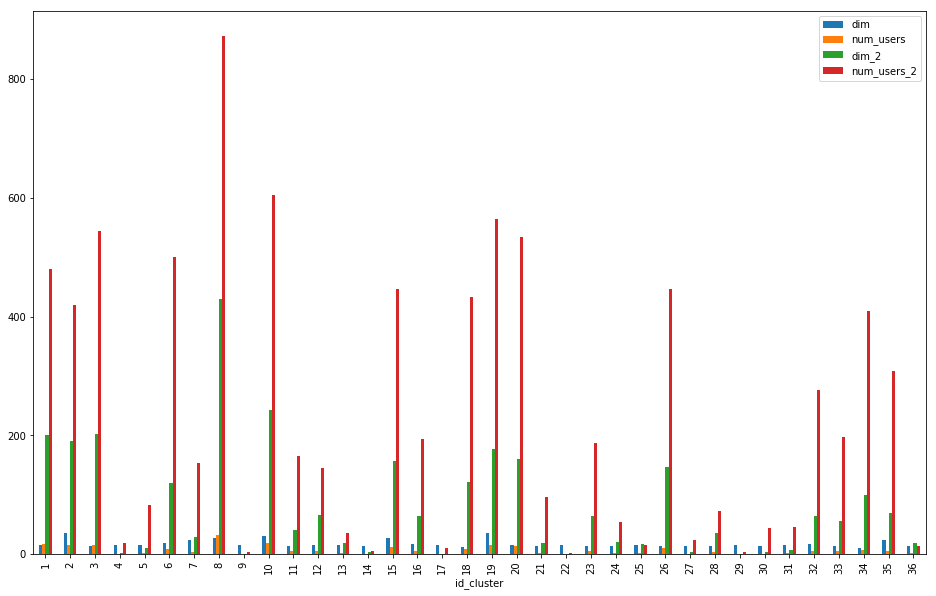

In [45]:
second_step.plot(kind='bar', figsize=(16,10))

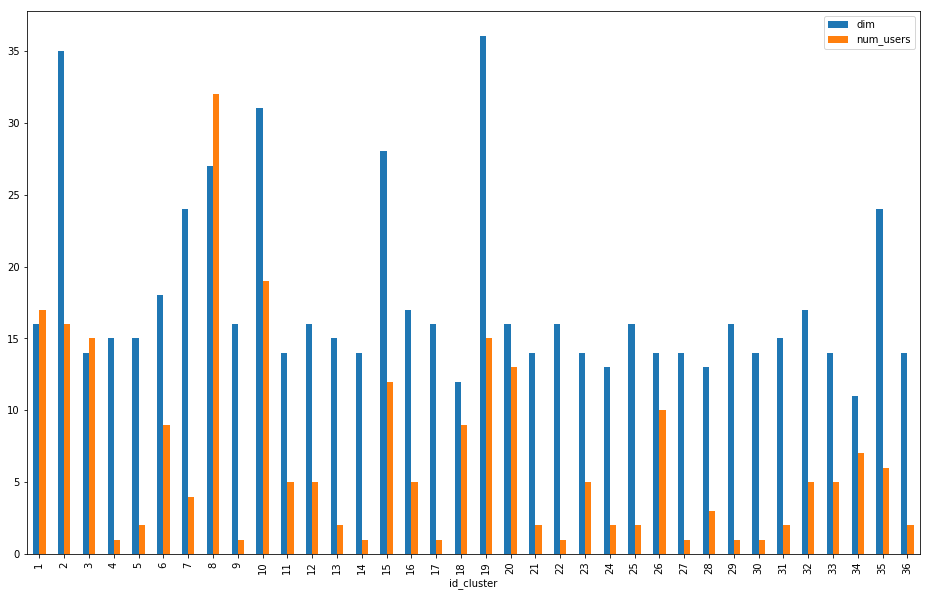

In [46]:
second_step[['dim', 'num_users']].plot(kind='bar', figsize=(16,10))

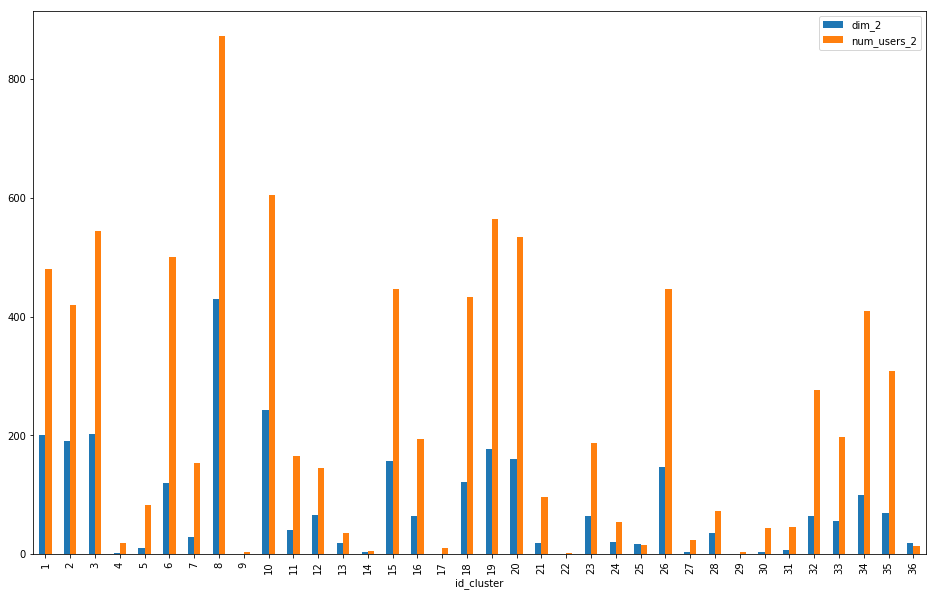

In [47]:
second_step[['dim_2', 'num_users_2']].plot(kind='bar', figsize=(16,10))